In [1]:
import subprocess
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import mne
from mne.datasets import sample
from mne.utils import running_subprocess
from mne_realtime import StimServer, MockRtClient
from mne.decoding import Vectorizer


import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import glob


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from mne.decoding import (
    SlidingEstimator,
    GeneralizingEstimator,
    Scaler,
    cross_val_multiscore,
    LinearModel,
    get_coef,
    Vectorizer,
    CSP,
)
import numpy as np
from mne.preprocessing import ICA

from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from mne_realtime import LSLClient, MockLSLStream

In [2]:
files = glob.glob('../files/S001/*.edf')
raws = []
f = [5,9,13]
# ,6,10,14]
for i in f:
    print(i)
    current_file = files[i-1]
    r = read_raw_edf(current_file, preload=True, stim_channel='auto')
    events, _ = mne.events_from_annotations(r)
    if i in [5, 9, 13]:
        new_labels_events = {1:'rest', 2:'action_hand', 3:'action_feet'} # action
    else:
        new_labels_events = {1:'rest', 2:'imagine_hand', 3:'imagine_feet'} # imagine
    new_annot = mne.annotations_from_events(events=events, event_desc=new_labels_events, sfreq=r.info['sfreq'], orig_time=r.info['meas_date'])
    r.set_annotations(new_annot)
    raws.append(r)
    
raw = concatenate_raws(raws)

5
Extracting EDF parameters from /Users/owalid/42/post_intership/total-perspective-vortex/files/S001/S001R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
9
Extracting EDF parameters from /Users/owalid/42/post_intership/total-perspective-vortex/files/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
13
Extracting EDF parameters from /Users/owalid/42/post_intership/total-perspective-vortex/files/S001/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Used Annotations descriptions: ['T0']


In [30]:
mne.find_events(raw, stim_channel='STI 014')

ValueError: No stim channel found to extract event triggers.

[3, 4, 4, 3, 4]
40
Running subprocess: /Users/owalid/.pyenv/versions/3.8.12/bin/python rt_feedback_client.py
Shutting down ...


ValueError: No stim channels found, but the raw object has annotations. Consider using mne.events_from_annotations to convert these to events.

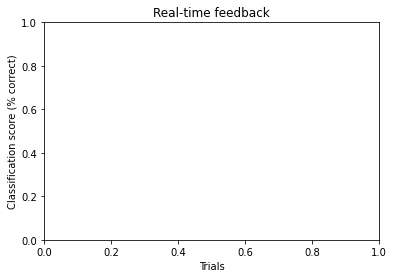

In [32]:

# raw = mne.io.read_info('./sample_audvis-ave.fif')

fig, ax = plt.subplots(1)
ax.set(xlabel='Trials', ylabel='Classification score (% correct)',
       title='Real-time feedback')
isi = 0.01  # this is unrealistic, but will make the example run quickly
n_trials = 40  # number of trials to simulate
n_start = 5  # number of trials to run before decoding
rng = np.random.RandomState(0)

# Instantiating stimulation server
# The with statement is necessary to ensure a clean exit
with StimServer(port=4218) as stim_server:

    # The channels to be used while decoding
    # picks = mne.pick_types(raw.info, meg='grad')
    picks = mne.pick_types(raw.info, meg=True, eeg=True, stim=False, eog=False, exclude='bads')

    rt_client = MockRtClient(raw)

    # Constructing the pipeline for classification
    # don't highpass filter because of short signal length of epochs
    scaler = preprocessing.StandardScaler()
    vectorizer = Vectorizer()
    clf = SVC(C=1, kernel='linear')
    concat_classifier = Pipeline([('vector', vectorizer),
                                  ('scaler', scaler), ('svm', clf)])
    ev_list = list(rng.randint(3, 5, n_start))  # some random starting events
    score_lv, score_rv, score_x = [], [], []
    print(ev_list)
    print(n_trials)
    command = [sys.executable, 'rt_feedback_client.py']
    with running_subprocess(command, after='kill',
                            stdout=subprocess.PIPE, stderr=subprocess.PIPE):
        for ii in range(len(ev_list)):
    #         # Tell the stim_client about the next stimuli
            stim_server.add_trigger(ev_list[ii])
            f = rt_client.get_event_data(event_id=ev_list[ii], tmin=-0.2,
                                             tmax=0.5, picks=picks)[None, ...]
            print(f.shape)
            exit()
            # Collecting data
            if ii == 0:
                X = rt_client.get_event_data(event_id=ev_list[ii], tmin=-0.2,
                                             tmax=0.5, picks=picks)[None, ...]
                y = ev_list[ii]
            else:
                X_temp = rt_client.get_event_data(
                    event_id=ev_list[ii], tmin=-0.2, tmax=0.5, picks=picks)
                X_temp = X_temp[np.newaxis]
                X = np.concatenate((X, X_temp), axis=0)
                time.sleep(isi)  # simulating the isi
                y = np.append(y, ev_list[ii])

            # Start decoding after collecting sufficient data
            if ii >= n_start - 1:
                # Now start doing rtfeedback
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=rng)
                y_pred = concat_classifier.fit(X_train,
                                               y_train).predict(X_test)
                cm = confusion_matrix(y_test, y_pred)
                score_lv.append(float(cm[0, 0]) / sum(cm, 1)[0] * 100)
                score_rv.append(float(cm[1, 1]) / sum(cm, 1)[1] * 100)
                score_x.append(ii + 1)

                # add events for the lower-performing class
                ev_list.append(3 if score_lv[-1] < score_rv[-1] else 4)
                print('Trial %d accuracy: %0.1f%%'
                      % (ii + 1, np.mean([score_lv[-1], score_rv[-1]])))

                # Now plot the accuracy
                lvh = ax.plot(score_x[-2:], score_lv[-2:],
                              c='r', marker='o', ls='-')[0]
                rvh = ax.plot(score_x[-2:], score_rv[-2:],
                              c='b', marker='o', ls='-')[0]
                ax.set(ylim=[0, 100])
                ax.legend((lvh, rvh), ('LV', 'RV'), loc='upper left')
                plt.draw()
                plt.pause(0.01)


Client: Waiting for server to start
Looking for LSL stream localhost...
localhost not found in streams: []


2023-08-27 00:03:40.510 (   0.001s) [          21BC58]      netinterfaces.cpp:91    INFO| netif 'lo0' (status: 32768, multicast: 1, broadcast: 0)
2023-08-27 00:03:40.510 (   0.001s) [          21BC58]      netinterfaces.cpp:91    INFO| netif 'lo0' (status: 32768, multicast: 1, broadcast: 0)
2023-08-27 00:03:40.510 (   0.001s) [          21BC58]      netinterfaces.cpp:102   INFO| 	IPv4 addr: 7f000001
2023-08-27 00:03:40.510 (   0.001s) [          21BC58]      netinterfaces.cpp:91    INFO| netif 'lo0' (status: 32768, multicast: 1, broadcast: 0)
2023-08-27 00:03:40.511 (   0.001s) [          21BC58]      netinterfaces.cpp:105   INFO| 	IPv6 addr: ::1
2023-08-27 00:03:40.511 (   0.001s) [          21BC58]      netinterfaces.cpp:91    INFO| netif 'lo0' (status: 32768, multicast: 1, broadcast: 0)
2023-08-27 00:03:40.511 (   0.001s) [          21BC58]      netinterfaces.cpp:105   INFO| 	IPv6 addr: fe80::1%lo0
2023-08-27 00:03:40.511 (   0.001s) [          21BC58]      netinterfaces.cpp:91    I

Looking for LSL stream localhost...
Found stream 'MNE' via localhost...
Client: Connected
160
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
False
(1, 64, 1)
<class 'numpy.ndarray'>
160
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
False
(1, 64, 1)
<class 'numpy.ndarray'>
160
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
False
(1, 64, 1)
<class 'numpy.ndarray'>
160
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
False
(1, 64, 1)
<class 'numpy.ndarray'>
Streams closed


2023-08-27 00:03:41.099 (  31.174s) [R_MNE           ]      data_receiver.cpp:342    ERR| Stream transmission broke off (Input stream error.); re-connecting...


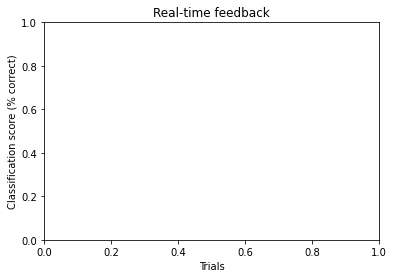

In [4]:

# raw = mne.io.read_info('./sample_audvis-ave.fif')

fig, ax = plt.subplots(1)
ax.set(xlabel='Trials', ylabel='Classification score (% correct)',
       title='Real-time feedback')
isi = 0.01  # this is unrealistic, but will make the example run quickly
n_trials = 40  # number of trials to simulate
n_start = 5  # number of trials to run before decoding
rng = np.random.RandomState(0)
host = 'localhost'
n_epochs = 150
i = 0
old_epoch = np.array([])
with MockLSLStream(host, raw, 'eeg'):
    with LSLClient(info=raw.info, host=host, wait_max=5, buffer_size=1) as client:
        while True:
            client_info = client.get_measurement_info()
            sfreq = int(client_info['sfreq'])
            print(sfreq)
            epoch = client.get_data_as_epoch(n_samples=sfreq)
            is_eq = np.array_equal(epoch, old_epoch)
            old_epoch = epoch
            print(is_eq)
            print(epoch.get_data().shape)
            print(type(epoch.get_data()))
            if i > 2:
                break
            i += 1
            # # let's observe ten seconds of data
            # for ii in range(n_epochs):
            #     print('Got epoch %d/%d' % (ii + 1, n_epochs))
            #     plt.cla()
            #     epoch.average().plot(axes=ax)
            #     plt.pause(1.)
            # plt.draw()
print('Streams closed')